<a href="https://colab.research.google.com/github/kwanqing/CMPE-257-Fall23-Jeffrey-Ong/blob/homework_4/Homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1 – the basic SVM classifier

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [6]:
# Load the train and test datasets
train_data = pd.read_csv('ZipDigits.train', header=None, sep=' ')
test_data = pd.read_csv('ZipDigits.test', header=None, sep=' ')

# Convert labels to binary classification
train_data[0] = train_data[0].apply(lambda x: 1 if x == 1 else -1)
test_data[0] = test_data[0].apply(lambda x: 1 if x == 1 else -1)

# Drop columns with NaN values
train_data = train_data.dropna(axis=1)
test_data = test_data.dropna(axis=1)

In [7]:
train_data.shape, test_data.shape

((7291, 257), (2007, 257))

In [8]:
def calculate_features(data):
    intensity_list = []
    symmetry_list = []
    labels = data[0].values

    for index, row in data.iterrows():
        pixels = row[1:].values

        # Calculate intensity
        intensity = np.mean(pixels)

        # Calculate symmetry
        left_half = pixels[:128]
        right_half = np.flip(pixels[128:])
        symmetry = -np.mean(np.abs(left_half - right_half))

        intensity_list.append(intensity)
        symmetry_list.append(symmetry)

    return intensity_list, symmetry_list, labels

def extract_features(intensity_list, symmetry_list, labels):
    x = np.column_stack((intensity_list, symmetry_list))
    y = labels
    return x, y

In [9]:
intensity_list_train, symmetry_list_train, labels_train = calculate_features(train_data)

In [10]:
x_train, y_train = extract_features(intensity_list_train, symmetry_list_train, labels_train)

In [11]:
x_train.shape, y_train.shape

((7291, 2), (7291,))

In [12]:
# Create SVM classifiers with different kernels
svm_linear = SVC(kernel='linear', C=1)
svm_poly = SVC(kernel='poly', degree=3, C=1)
svm_rbf = SVC(kernel='rbf', C=1)

svm_linear.fit(x_train, y_train)
svm_poly.fit(x_train, y_train)
svm_rbf.fit(x_train, y_train)

y_pred_linear = svm_linear.predict(x_train)
y_pred_poly = svm_poly.predict(x_train)
y_pred_rbf = svm_rbf.predict(x_train)

# Calculate training errors
error_linear_training = 1 - accuracy_score(y_train, y_pred_linear)
error_poly_training = 1 - accuracy_score(y_train, y_pred_poly)
error_rbf_training = 1 - accuracy_score(y_train, y_pred_rbf)

print(f"Training Error with Linear Kernel: {error_linear_training}")
print(f"Training Error with Polynomial Kernel: {error_poly_training}")
print(f"Training Error with RBF Kernel: {error_rbf_training}")

Training Error with Linear Kernel: 0.01906460019201761
Training Error with Polynomial Kernel: 0.020298998765601373
Training Error with RBF Kernel: 0.01645864764778493


Based on the results above, the RBF kernel has the lowest error (0.01646), followed by the linear kernel (0.01906), and then the polynomial kernel (0.02030). In my opinion, this is not an appropriate way
to select a model because there are multiple reasons like overfitting concerns and validation techniques.

1. Overfitting Concerns: A model with the lowest training error may overfit the training data like it might not perform well on those unseen data due to its over-specialization on training set.

2. Validation Techniques: Methods like cross-validation are more appropriate for model selection because they provide a better estimate of how a model performs on unseen data and reducing the chance of an overfitting bias.

# Task 2 – Cross validation

In [13]:
# Define the parameter grid: kernel types and C values
param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.01, 0.1, 1, 10, 100],
    'degree': [3]  # Only for the polynomial kernel
}

svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_train, y_train)

results = grid_search.cv_results_

for params, mean_test_score in zip(results['params'], results['mean_test_score']):
    print(f"Parameters: {params}, Cross-Validation Error: {1 - mean_test_score}")

Parameters: {'C': 0.01, 'degree': 3, 'kernel': 'linear'}, Cross-Validation Error: 0.13784118441798743
Parameters: {'C': 0.01, 'degree': 3, 'kernel': 'poly'}, Cross-Validation Error: 0.020162446608769535
Parameters: {'C': 0.01, 'degree': 3, 'kernel': 'rbf'}, Cross-Validation Error: 0.0167330913275624
Parameters: {'C': 0.1, 'degree': 3, 'kernel': 'linear'}, Cross-Validation Error: 0.019201851052687458
Parameters: {'C': 0.1, 'degree': 3, 'kernel': 'poly'}, Cross-Validation Error: 0.020162446608769535
Parameters: {'C': 0.1, 'degree': 3, 'kernel': 'rbf'}, Cross-Validation Error: 0.016870171519474675
Parameters: {'C': 1, 'degree': 3, 'kernel': 'linear'}, Cross-Validation Error: 0.01906467684143931
Parameters: {'C': 1, 'degree': 3, 'kernel': 'poly'}, Cross-Validation Error: 0.020025272397521277
Parameters: {'C': 1, 'degree': 3, 'kernel': 'rbf'}, Cross-Validation Error: 0.016595823096978046
Parameters: {'C': 10, 'degree': 3, 'kernel': 'linear'}, Cross-Validation Error: 0.019201851052687458
Par

In [14]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_
print(f"\nBest Parameters: {best_parameters}, Best Cross-Validation Score: {best_score}")


Best Parameters: {'C': 1, 'degree': 3, 'kernel': 'rbf'}, Best Cross-Validation Score: 0.983404176903022


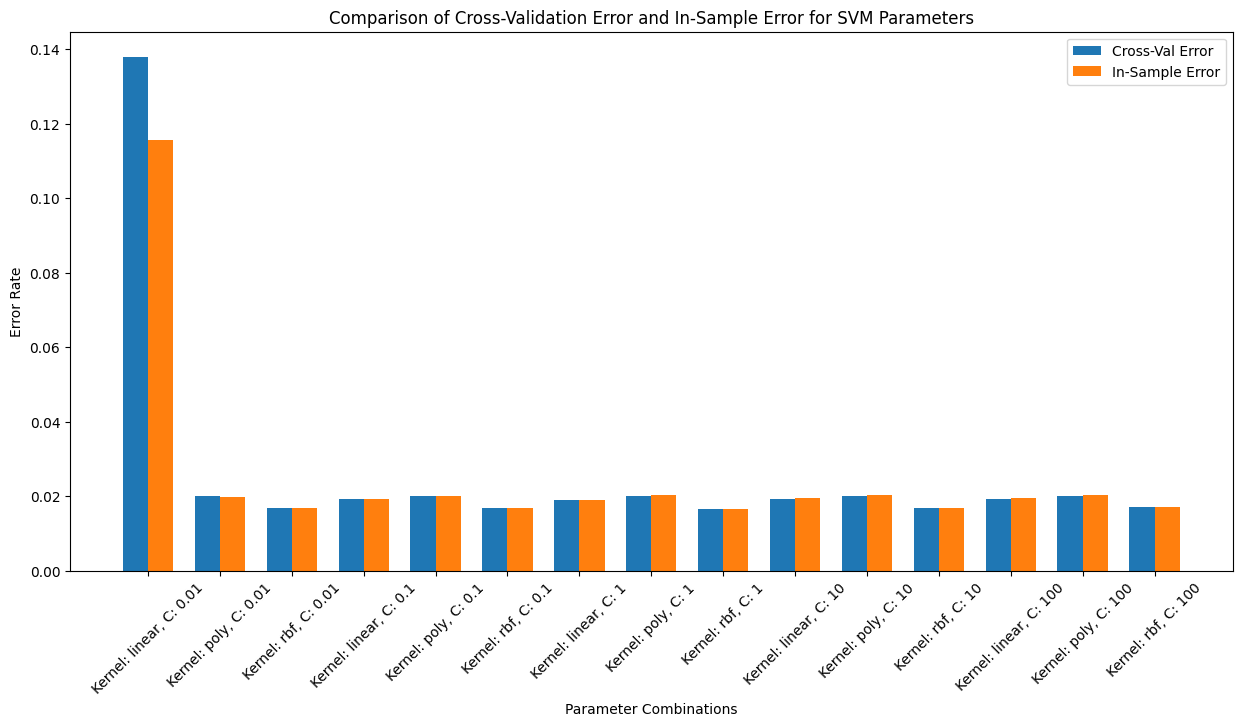

In [15]:
parameter_combinations = [f"Kernel: {p['kernel']}, C: {p['C']}" for p in results['params']]
cross_val_errors = [1 - score for score in results['mean_test_score']]

# Calculate in-sample errors
in_sample_errors = []
for params in results['params']:
    svm.set_params(**params)
    svm.fit(x_train, y_train)
    y_pred = svm.predict(x_train)
    in_sample_error = 1 - accuracy_score(y_train, y_pred)
    in_sample_errors.append(in_sample_error)

fig, ax = plt.subplots(figsize=(15, 7))
x = np.arange(len(parameter_combinations))
width = 0.35

ax.bar(x - width/2, cross_val_errors, width, label='Cross-Val Error')
ax.bar(x + width/2, in_sample_errors, width, label='In-Sample Error')

ax.set_xlabel('Parameter Combinations')
ax.set_ylabel('Error Rate')
ax.set_title('Comparison of Cross-Validation Error and In-Sample Error for SVM Parameters')
ax.set_xticks(x)
ax.set_xticklabels(parameter_combinations, rotation=45)
ax.legend()

plt.show()

The in-sample error is significantly lower than the cross-validation error may indicate overfitting. The model performs well on the training data but doesn't generalize effectively to new and unseen data. The parameter combination with the lowest cross-validation error is typically preferred because it suggests better generalization. However, it is also important to consider the difference between the in-sample and cross-validation errors to avoid overfit models. Our main goal is to find a balance where both errors are low, indicating that the model not only fits the training data well but also generalizes effectively to unseen data.

#Task 3 – The final hypothesis

In [16]:
svm_final = SVC(**best_parameters)

svm_final.fit(x_train, y_train)

y_train_pred = svm_final.predict(x_train)

in_sample_error = 1 - accuracy_score(y_train, y_train_pred)
print(f"In-Sample Error: {in_sample_error}")

In-Sample Error: 0.01645864764778493


In [17]:
intensity_list_test, symmetry_list_test, labels_test = calculate_features(test_data)

In [18]:
x_test, y_test = extract_features(intensity_list_test, symmetry_list_test, labels_test)

In [19]:
x_test.shape, y_test.shape

((2007, 2), (2007,))

In [20]:
# Create SVM classifiers with different kernels
svm_linear = SVC(kernel='linear', C=1)
svm_poly = SVC(kernel='poly', degree=3, C=1)
svm_rbf = SVC(kernel='rbf', C=1)

svm_linear.fit(x_test, y_test)
svm_poly.fit(x_test, y_test)
svm_rbf.fit(x_test, y_test)

y_pred_linear = svm_linear.predict(x_test)
y_pred_poly = svm_poly.predict(x_test)
y_pred_rbf = svm_rbf.predict(x_test)

# Calculate test errors
error_linear_testing = 1 - accuracy_score(y_test, y_pred_linear)
error_poly_testing = 1 - accuracy_score(y_test, y_pred_poly)
error_rbf_testing = 1 - accuracy_score(y_test, y_pred_rbf)

print(f"Training Error with Linear Kernel: {error_linear_testing}")
print(f"Training Error with Polynomial Kernel: {error_poly_testing}")
print(f"Training Error with RBF Kernel: {error_rbf_testing}")

Training Error with Linear Kernel: 0.02391629297458897
Training Error with Polynomial Kernel: 0.027902341803687114
Training Error with RBF Kernel: 0.022421524663677084


In [21]:
svm = SVC()

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

grid_search.fit(x_test, y_test)

results = grid_search.cv_results_

for params, mean_test_score in zip(results['params'], results['mean_test_score']):
    print(f"Parameters: {params}, Cross-Validation Error: {1 - mean_test_score}")

Parameters: {'C': 0.01, 'degree': 3, 'kernel': 'linear'}, Cross-Validation Error: 0.1315393109266635
Parameters: {'C': 0.01, 'degree': 3, 'kernel': 'poly'}, Cross-Validation Error: 0.0293916948921229
Parameters: {'C': 0.01, 'degree': 3, 'kernel': 'rbf'}, Cross-Validation Error: 0.029387972853934796
Parameters: {'C': 0.1, 'degree': 3, 'kernel': 'linear'}, Cross-Validation Error: 0.02391285467922233
Parameters: {'C': 0.1, 'degree': 3, 'kernel': 'poly'}, Cross-Validation Error: 0.027897916899293995
Parameters: {'C': 0.1, 'degree': 3, 'kernel': 'rbf'}, Cross-Validation Error: 0.02341782360020339
Parameters: {'C': 1, 'degree': 3, 'kernel': 'linear'}, Cross-Validation Error: 0.02391285467922233
Parameters: {'C': 1, 'degree': 3, 'kernel': 'poly'}, Cross-Validation Error: 0.027400404461483063
Parameters: {'C': 1, 'degree': 3, 'kernel': 'rbf'}, Cross-Validation Error: 0.022919070482996462
Parameters: {'C': 10, 'degree': 3, 'kernel': 'linear'}, Cross-Validation Error: 0.024411607796429258
Parame

In [22]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_
print(f"\nBest Parameters: {best_parameters}, Best Cross-Validation Score: {best_score}")


Best Parameters: {'C': 1, 'degree': 3, 'kernel': 'rbf'}, Best Cross-Validation Score: 0.9770809295170035


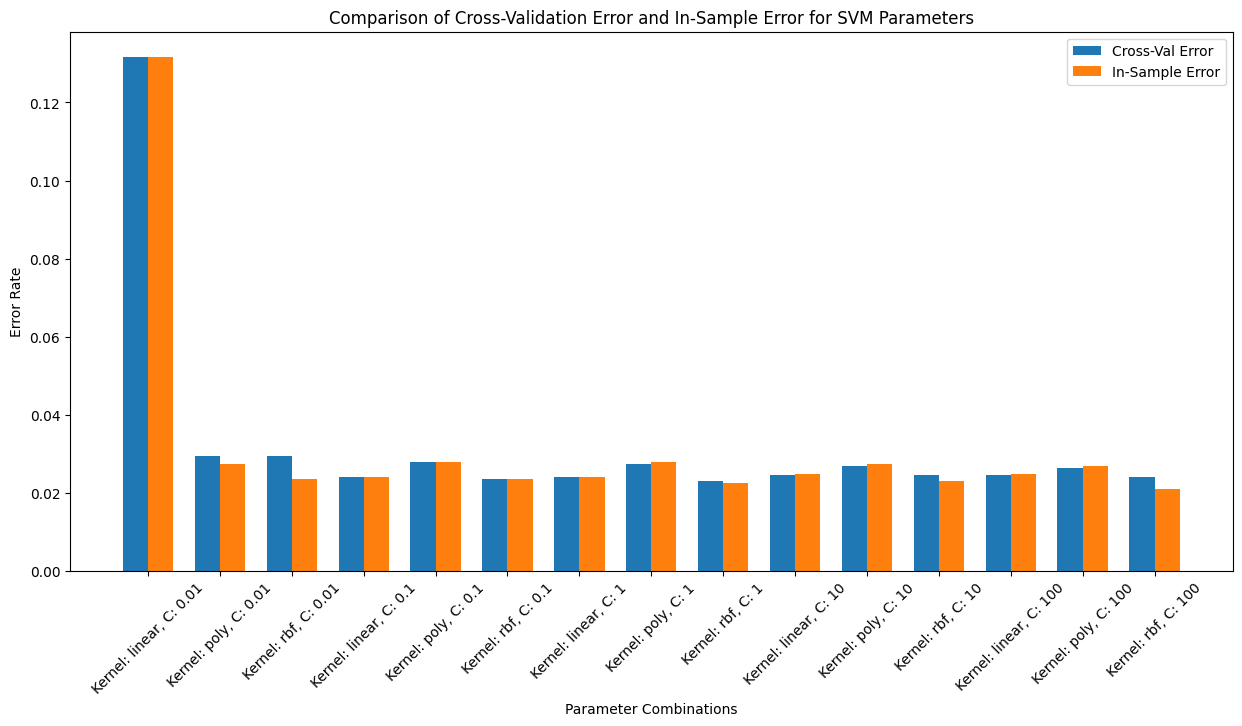

In [23]:
parameter_combinations = [f"Kernel: {p['kernel']}, C: {p['C']}" for p in results['params']]
cross_val_errors = [1 - score for score in results['mean_test_score']]

# Calculate in-sample errors
in_sample_errors = []
for params in results['params']:
    svm.set_params(**params)
    svm.fit(x_test, y_test)
    y_pred = svm.predict(x_test)
    in_sample_error = 1 - accuracy_score(y_test, y_pred)
    in_sample_errors.append(in_sample_error)

fig, ax = plt.subplots(figsize=(15, 7))
x = np.arange(len(parameter_combinations))
width = 0.35

ax.bar(x - width/2, cross_val_errors, width, label='Cross-Val Error')
ax.bar(x + width/2, in_sample_errors, width, label='In-Sample Error')

ax.set_xlabel('Parameter Combinations')
ax.set_ylabel('Error Rate')
ax.set_title('Comparison of Cross-Validation Error and In-Sample Error for SVM Parameters')
ax.set_xticks(x)
ax.set_xticklabels(parameter_combinations, rotation=45)
ax.legend()

plt.show()

In [24]:
svm_final = SVC(**best_parameters)

svm_final.fit(x_train, y_train)

y_test_pred = svm_final.predict(x_test)

test_error = 1 - accuracy_score(y_test, y_test_pred)
print(f"Final Test Error: {test_error}")

Final Test Error: 0.02291978076731438


# Task 4 – Overall Learning approach

In [25]:
def pla(X, Y, max_iter=1000):
    w = np.zeros(X.shape[1])

    for _ in range(max_iter):
        misclassified = False

        for i in range(X.shape[0]):
            if Y[i] * np.dot(w, X[i, :]) <= 0:
                w = w + Y[i] * X[i, :]
                misclassified = True

        if not misclassified:
            break
    return w

# Run PLA
w_PLA = pla(x_train, y_train)
w_PLA

array([-1.30020703,  3.26347656])

In [26]:
def pocket_algorithm(X, Y, max_iter=1000):
    w = np.zeros(X.shape[1])
    w_pocket = np.copy(w)
    min_error = float('inf')

    for _ in range(max_iter):
        for i in range(X.shape[0]):
            if Y[i] * np.dot(w, X[i, :]) <= 0:
                w = w + Y[i] * X[i, :]
                current_error = np.sum(Y * np.dot(X, w) <= 0)
                if current_error < min_error:
                    w_pocket = np.copy(w)
                    min_error = current_error
    return w_pocket


# Run Pocket Algorithm
w_pocket = pocket_algorithm(x_train, y_train, max_iter=1000)
w_pocket

array([-1.00402344,  3.21715625])

In [27]:
def compute_error_rate(w, x, y):
    predictions = np.sign(np.dot(x, w))
    error_rate = np.mean(predictions != y)
    return error_rate

In [29]:
error_rate_pla = compute_error_rate(w_PLA, x_test, y_test)
error_rate_pocket = compute_error_rate(w_pocket, x_test, y_test)

print(f"Error rate for PLA: {error_rate_pla: }")
print(f"Error rate for Pocket Algorithm: {error_rate_pocket: }")

Error rate for PLA:  0.025411061285500747
Error rate for Pocket Algorithm:  0.023418036870951668


In [30]:
from sklearn.preprocessing import PolynomialFeatures

# Stack the features
x_train_original = np.column_stack((intensity_list_train, symmetry_list_train))

poly = PolynomialFeatures(3)

x_train_poly = poly.fit_transform(x_train_original)

x_train_poly.shape, x_train_poly[:5]

((7291, 10),
 array([[ 1.        , -0.31781641, -0.83767969,  0.10100727,  0.26622835,
          0.70170726, -0.03210177, -0.08461174, -0.22301408, -0.58780592],
        [ 1.        , -0.11173828, -1.01836719,  0.01248544,  0.1137906 ,
          1.03707173, -0.0013951 , -0.01271477, -0.11588061, -1.05611982],
        [ 1.        , -0.53799609, -0.53105469,  0.2894398 ,  0.28570535,
          0.28201908, -0.15571748, -0.15370836, -0.15172516, -0.14976755],
        [ 1.        , -0.59944922, -0.66136719,  0.35933937,  0.39645604,
          0.43740656, -0.2154057 , -0.23765527, -0.26220302, -0.28928634],
        [ 1.        , -0.41612891, -0.78058594,  0.17316327,  0.32482437,
          0.60931441, -0.07205824, -0.13516881, -0.25355334, -0.47562226]]))

In [31]:
w_pocket_transformed = pocket_algorithm(x_train_poly, y_train, max_iter=1000)
w_pocket_transformed

array([-5.        , -7.19141797, -0.08516406, 17.22315982, -7.72214   ,
        5.68526187, 15.09593988, 17.00373887,  4.15289652,  2.69237289])

In [32]:
x_test_original = np.column_stack((intensity_list_test, symmetry_list_test))

poly = PolynomialFeatures(3)

x_test_poly = poly.fit_transform(x_test_original)

x_test_poly.shape, x_test_poly[:5]

((2007, 10),
 array([[ 1.        , -0.45564453, -0.71658594,  0.20761194,  0.32650846,
          0.51349541, -0.09459724, -0.1487718 , -0.23397137, -0.36796359],
        [ 1.        , -0.46973437, -0.7153125 ,  0.22065038,  0.33600687,
          0.51167197, -0.10364707, -0.15783398, -0.24034991, -0.36600536],
        [ 1.        , -0.32814844, -0.50671875,  0.1076814 ,  0.16627897,
          0.25676389, -0.03533548, -0.05456418, -0.08425667, -0.13010708],
        [ 1.        , -0.47030078, -0.58339844,  0.22118282,  0.27437274,
          0.34035374, -0.10402246, -0.12903771, -0.16006863, -0.19856184],
        [ 1.        , -0.30932422, -0.88935156,  0.09568147,  0.27509798,
          0.7909462 , -0.0295966 , -0.08509447, -0.24465882, -0.70342924]]))

In [33]:
# Compute test error
error_rate_pocket_transformed = compute_error_rate(w_pocket_transformed, x_test_poly, y_test)

print(f"Error rate for Pocket_transformed: {error_rate_pocket_transformed: }")

Error rate for Pocket_transformed:  0.02391629297458894


In [37]:
# error_rate_pla = 0.025411061285500747
# error_rate_pocket = 0.023418036870951668
# error_rate_pocket_transformed = 0.02391629297458894
error_stochastic_gradient_descent = 0.4936365254538982
error_mini_batch_gradient_descent = 0.37735849056603776
# error_linear_testing,
# error_poly_testing,
# error_rbf_testing,
# test_error

In [42]:
test_errors = {
    'Model': [
        'Perceptron Learning Algorithm (PLA)',
        'Pocket Algorithm',
        'Pocket with 3rd Order Polynomial',
        'Neural Network (Stochastic Gradient Descent)',
        'Neural Network (Mini Batch Gradient Descent)',
        'SVM (RBF Kernal)'
    ],
    'Test Error': [
        error_rate_pla,
        error_rate_pocket,
        error_rate_pocket_transformed,
        error_stochastic_gradient_descent,
        error_mini_batch_gradient_descent,
        test_error
    ]
}

error_df = pd.DataFrame(test_errors)
error_df

,Model,Test Error
0,Perceptron Learning Algorithm (PLA),0.025411
1,Pocket Algorithm,0.023418
2,Pocket with 3rd Order Polynomial,0.023916
3,Neural Network (Stochastic Gradient Descent),0.493637
4,Neural Network (Mini Batch Gradient Descent),0.377358
5,SVM (RBF Kernal),0.022920


[HP1]

Based on the results above, the SVM (RBF kernel) has the best performance with a test error of 0.02292, and the Neural Network trained with Stochastic Gradient Descent has the worst performance with a test error of 0.493637.

The SVM model's capability to effectively separate classes with an optimal margin and handle non-linearities (through kernel trick) likely contributes to its best performance. In contrast, the SGD Neural Network's issues with variance in learning and potential overfitting or architectural shortcomings might be the reasons for its worst performance.

[HP2]

Choosing the best digit classifier based solely on test error may not be entirely appropriate or the best way due to several factors like:

1. Model complexity and overfitting - Different models have varying levels of complexity.

2. Cross-Validation and Parameter Tuning:  Proper tuning of hyperparameters (like learning rate for neural networks, kernel type and C value for SVM) is essential for optimal performance.

Better approach to choose the best digit classifier:
1. Using a sufficiently large and diverse dataset to train and validate the models.

2. Employing techniques like k-fold cross-validation to assess model performance.

3. Balancing model complexity with the risk of overfitting, considering the dataset size.

4. Tuning model parameters appropriately.

5. Considering computational resources and the need for model interpretability based on the specific application.